In [1]:
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm
from shapely.geometry import Point
import shapely.vectorized
# import geopandas as gpd
from shapely.prepared import prep
import scipy.interpolate

In [2]:
#select first  date

rural_data = pd.read_csv("Rural_NaNdeleted.csv", delimiter = ",", low_memory=False)
urban_data = pd.read_csv("Urban_NaNdeleted.csv", delimiter = ",", low_memory=False)

# print(urban_data.keys())

rural_lats = rural_data["lat"].unique()
rural_lons = rural_data["lon"].unique()

urban_lats = urban_data["lat"].unique()
urban_lons = urban_data["lon"].unique()

# get the variogram over all time
# rural_date = rural_data[rural_data.lat==rural_lats[0]].date
# n_times = len(rural_date)

# date0 = rural_data.iloc[0].date
# rural_data0 = rural_data[rural_data["date"]==date0]
# rural_no2_0 = rural_data0.no2.to_numpy()
# rural_lat_0 = rural_data0.lat.to_numpy()
# rural_lon_0 = rural_data0.lon.to_numpy()

# n_points = len(rural_lat_0)
# n_pairs = int(n_points*(n_points-1)/2)

# distances = np.zeros(n_pairs)
# no2_diffs = np.zeros(n_pairs * n_times)

# for i in range(n_points):
#     for j in range(i+1, n_points):
#         distances[i+j-1] = ((rural_lat_0[i]-rural_lat_0[j])**2 + (rural_lon_0[i]-rural_lon_0[j])**2)**0.5
#         no2_diffs[(i+j-1)*n_times:(i+j)*n_times] = 0.5 * (rural_data[rural_data["lat"]==rural_lat_0[i]].no2.to_numpy()
#                                    -rural_data[rural_data["lat"]==rural_lat_0[j]].no2.to_numpy())**2
# print(distances)
# distances = np.concatenate([distances for i in range(n_times)])


# first, pick a single time and focus on rural data
date0 = rural_data.iloc[0].date
rural_data0 = rural_data[rural_data["date"]==date0]
rural_no2_0 = rural_data0.no2.to_numpy()
rural_lat_0 = rural_data0.lat.to_numpy()
rural_lon_0 = rural_data0.lon.to_numpy()

n_points = len(rural_lat_0)
print(n_points)
n_pairs = int(n_points*(n_points-1)/2)

21


In [3]:
# generate mesh of points we want to interpolate
minlat = 50.5
maxlat = 54
latgrid = np.arange(minlat, maxlat, 0.01)

minlon = 3
maxlon = 7.5
longrid = np.arange(minlon, maxlon, 0.01)

XX, YY = np.meshgrid(longrid, latgrid)

interp_no2 = np.zeros(XX.shape)
XX.shape

(350, 450)

In [4]:
#function to plot the interpolation data

def plot_interp(XX,YY,interp_no2,urban_lons,urban_lats,rural_lons,rural_lats):
        # Downloaded from https://gadm.org/download_country.html
        fname = 'gadm41_NLD_1.shp' #0 is country border, 1 is provinces, 2 is municipalities

        adm1_shapes = list(shpreader.Reader(fname).geometries())
        borders = list(shpreader.Reader('gadm41_NLD_0.shp').geometries())
        borders_prep = [prep(b_) for b_ in borders]
        nb = len(borders_prep)
        
        regions_prep = [prep(r_) for r_ in adm1_shapes]
        regions_prep.pop(5)   #regions where we do not have data
        regions_prep.pop(11)
        nr = len(regions_prep)

        points = np.empty(XX.shape, dtype=object)
        contains = np.empty((XX.shape[0], XX.shape[1], nr), dtype=bool)
        # contains = np.empty((XX.shape[0], XX.shape[1]), dtype=bool)
        for i in range(XX.shape[0]):
            #print(i)
            for j in range(XX.shape[1]):                              
                contains[i, j, :] = [b_.contains(Point(XX[i, j], YY[i, j])) for b_ in regions_prep]
                # contains[i, j] = regions_prep[14].contains(Point(XX[i, j], YY[i, j])
        
        contains = np.any(contains, axis=2)
        print(contains.shape)

        # print(contains)
        # gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

        # mask = shapely.vectorized.contains(gdf.dissolve().geometry.item(), XX, YY)
        masked_no2 = np.where(contains, interp_no2, np.nan)

        fig = plt.figure(figsize=(8,6))
        ax = plt.axes(projection=ccrs.Mercator())

        plt.title("NO2 Concentrations on "+str(date0)+" (Kriging)")
        ax.coastlines(resolution='10m')

        ax.set_extent([3, 7.5, 50.5, 54], ccrs.Mercator())

        ax.plot(urban_lons, urban_lats, ".", markersize=10, transform=ccrs.Mercator(), label="Urban Data")
        ax.plot(rural_lons, rural_lats, ".", markersize=10, transform=ccrs.Mercator(), label="Rural Data")

        no2mesh = ax.pcolormesh(XX, YY, masked_no2, cmap=mpl.cm.get_cmap('Blues').reversed())

        ax.add_geometries(adm1_shapes, ccrs.Mercator(), linewidth=0.5,
                  edgecolor='white', facecolor='None', alpha=1)

        cbar = fig.colorbar(no2mesh, ax=ax)
        cbar.set_label("NO2 Concentration [$\mu g m^{-3}$]")

        ax.legend()
        
        return

        #plt.figure()
        #plt.plot(distances, no2_diffs, "k.")
        #plt.plot(bins, exp_vari, "r.--", markersize=8)
        #plt.plot(h_hires, vari_fit(h_hires), "g")

        #plt.show()

(350, 450)


C:\Users\benro\anaconda3\lib\site-packages\cartopy\crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
C:\Users\benro\anaconda3\lib\site-packages\cartopy\crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
C:\Users\benro\anaconda3\lib\site-packages\cartopy\crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


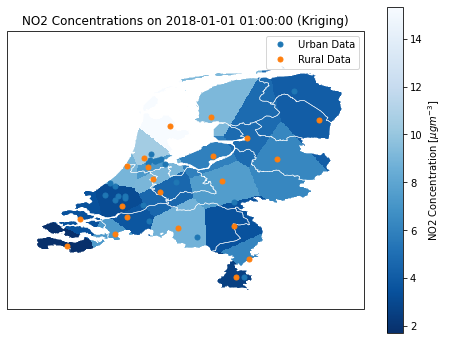

In [5]:
#nearest neighbour_test

NN=scipy.interpolate.NearestNDInterpolator((rural_lon_0,rural_lat_0),rural_no2_0)
no2_nearest=NN(XX,YY)

plot_interp(XX,YY,no2_nearest,urban_lons,urban_lats,rural_lons,rural_lats)

(350, 450)


C:\Users\benro\anaconda3\lib\site-packages\cartopy\crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
C:\Users\benro\anaconda3\lib\site-packages\cartopy\crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
C:\Users\benro\anaconda3\lib\site-packages\cartopy\crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


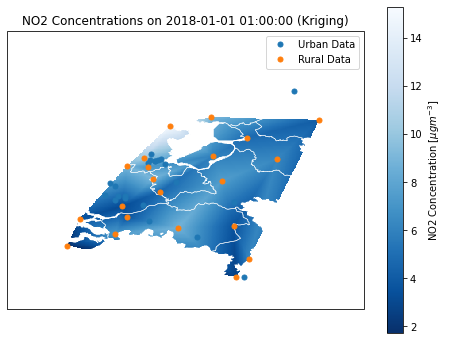

In [6]:
#linear regression

no2_linear=scipy.interpolate.griddata((rural_lon_0,rural_lat_0),rural_no2_0, (XX,YY),method='linear')
plot_interp(XX,YY,no2_linear,urban_lons,urban_lats,rural_lons,rural_lats)

(350, 450)


C:\Users\benro\anaconda3\lib\site-packages\cartopy\crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
C:\Users\benro\anaconda3\lib\site-packages\cartopy\crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
C:\Users\benro\anaconda3\lib\site-packages\cartopy\crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


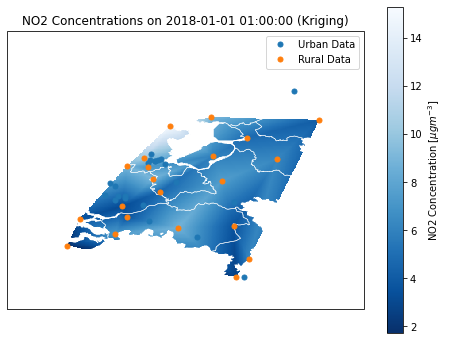

In [7]:
#linear regression

L=scipy.interpolate.LinearNDInterpolator((rural_lon_0,rural_lat_0),rural_no2_0)
no2_linear=L(XX,YY)

plot_interp(XX,YY,no2_linear,urban_lons,urban_lats,rural_lons,rural_lats)

[0.7816314  0.22108195]
trace:  4.642720861263392
Condition number is finite:  True
Determinant:  5.448983135088185e-07
(350, 450)


C:\Users\benro\anaconda3\lib\site-packages\cartopy\crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
C:\Users\benro\anaconda3\lib\site-packages\cartopy\crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
C:\Users\benro\anaconda3\lib\site-packages\cartopy\crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


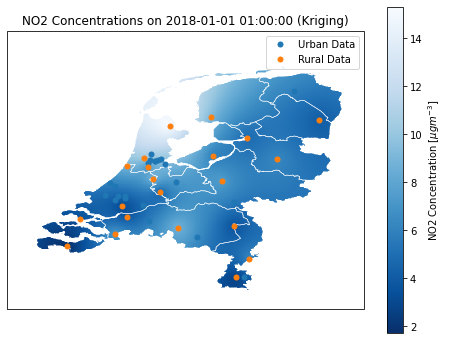

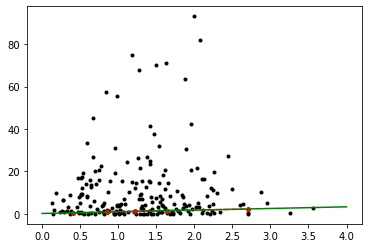

In [8]:
#Kriging

distances = np.zeros(n_pairs)
no2_diffs = np.zeros(n_pairs)

ind=0
for i in range(n_points):
    for j in range(i+1, n_points):
        distances[ind] = ((rural_lat_0[i]-rural_lat_0[j])**2 + (rural_lon_0[i]-rural_lon_0[j])**2)**0.5
        no2_diffs[ind] = 0.5 * (rural_no2_0[i]-rural_no2_0[j])**2
        ind += 1

# get experimental variogram from raw variogram with 5 intervals, spaced
# such that an equal number of raw data are in each interval
sorted_dists = np.split(np.sort(distances), 5)
dist_sorted_inds = np.argsort(distances)
dist_sorted_no2s = np.split(no2_diffs[dist_sorted_inds], 5)
bins = np.array([(d[0]+d[-1])/2 for d in sorted_dists])
exp_vari = np.array([np.mean(sno2) for sno2 in sorted_dists])

# bins = np.linspace(np.min(distances), np.max(distances), 5)
# bindiff = bins[1]-bins[0]
# bin_edges = np.array([centre-bindiff/2 for centre in bins]+[bins[-1]+bindiff/2])
# exp_vari = np.zeros(len(bins))

# for i in range(len(bins)):
#     exp_vari[i] = np.mean(no2_diffs[(no2_diffs>=bin_edges[i]) & (no2_diffs<bin_edges[i+1])])

# generate linear variogram model
FIT = np.polyfit(bins, exp_vari, 1)
vari_fit = np.poly1d(FIT)
print(FIT)

h_hires = np.linspace(0, 4, 1000)

# get model variogram matrix for kriging
distance_matrix = ((np.stack([rural_lat_0 for i in range(n_points)], axis=0)
              -np.stack([rural_lat_0 for i in range(n_points)], axis=1))**2 
            + (np.stack([rural_lon_0 for i in range(n_points)], axis=0)
            -np.stack([rural_lon_0 for i in range(n_points)], axis=1))**2)**0.5

# variogram_matrix = (np.stack([rural_no2_0 for i in range(n_points)], axis=0)
#               -np.stack([rural_no2_0 for i in range(n_points)], axis=1))**2 * 0.5

variogram_matrix = vari_fit(distance_matrix)

print("trace: ", np.trace(variogram_matrix)) # should be zero
print("Condition number is finite: ", np.isfinite(np.linalg.cond(variogram_matrix)))
print("Determinant: ", np.linalg.det(variogram_matrix))

inverse_variogram_matrix = np.linalg.inv(variogram_matrix)
# inverse_variogram_matrix = np.linalg.pinv(variogram_matrix)
# print(np.matmul(variogram_matrix, inverse_variogram_matrix)) # should return identity


# find weights
for i, x in enumerate(longrid):
    for j, y in enumerate(latgrid):
        interp_distances = np.array([((x-rural_lons[k])**2+(y-rural_lats[k])**2)**0.5 for k in range(n_points)])
        b = vari_fit(interp_distances)

        # print(b)

        weights = np.matmul(inverse_variogram_matrix, b)
        # weights /= np.sum(weights) # normalisation

        interp_no2[j, i] = np.dot(weights, rural_no2_0)


plot_interp(XX,YY,interp_no2,urban_lons,urban_lats,rural_lons,rural_lats)

plt.figure()
plt.plot(distances, no2_diffs, "k.")
plt.plot(bins, exp_vari, "r.--", markersize=8)
plt.plot(h_hires, vari_fit(h_hires), "g")

plt.show()

